# Introduction to global sensitivity analysis with Emukit

In [1]:
# General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import cm

## Figures config
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
LEGEND_SIZE = 15
TITLE_SIZE = 25
AXIS_SIZE = 15

## Overview

Sensitivity analysis is a statistical technique widely used to test the reliability of real systems. Imagine a simulator of taxis picking up customers in a city like the one showed in the <a href='https://github.com/amzn/emukit-playground'>Emukit playground</a>. The profit of the taxi company depends on factors like the number of taxis on the road and the price per trip. In this example, a global sensitivity analysis of the simulator could be useful to decompose the variance of the profit in a way that can be assigned to the input variables of the simulator.  

There are different ways of doing a sensitivity analysis of the variables of a simulator. In this notebook we will start with an approach based on Monte Carlo sampling that is useful when evaluating the simulator is cheap. If evaluating the simulator is expensive, emulators can then be used to speed up computations. We will show this in the last part of the notebook. Next, we start with a few formal definitions and literature review so we can understand the basics of Sensitivity Analysis and how it can performed with Emukit.

### Navigation

1. [Global sensitivity analysis with Sobol indexes and decomposition of variance](#1.-Global-sensitivity-analysis-with-Sobol-indexes-and-decomposition-of-variance)

2. [First order Sobol indices using Monte Carlo](#2.-First-order-Sobol-indices-using-Monte-Carlo)

3. [Total effects using Monte Carlo](#3.-Total-Effects-using-Monte-Carlo)

4. [Computing the sensitivity coefficients using the output of a model](#4.-Computing-the-sensitivity-coefficients-using-the-output-of-a-model)

4. [Conclusions](#4.-Conclusions)

5. [References](#5.-References)

## 1. Global sensitivity analysis with Sobol indexes and decomposition of variance

Any simulator can be viewed as a function 

$$y=f(\textbf{X})$$ 

where $\textbf{X}$ is a vector of $d$ uncertain model inputs $X_1,\dots,X_d$, and $Y$ is some univariate model output. We assume that $f$ is a square integrable function and that the inputs are statistically independent and uniformly distributed within the hypercube $X_i \in [0,1]$ for $i=1,2,...,d$, although the bounds can be generalized. The so-called Sobol decomposition of $f$ allows us to write it as 

$$Y = f_0 + \sum_{i=1}^d f_i(X_i) + \sum_{i<j}^{d} f_{ij}(X_i,X_j) + \cdots + f_{1,2,\dots,d}(X_1,X_2,\dots,X_d)$$

where $f_0$ is a constant term, $f_i$ is a function of $X_i$, $f_{ij}$ a function of $X_i$ and $X_j$, etc. A condition of this decomposition is that,

$$ \int_0^1 f_{i_1 i_2 \dots i_d}(X_{i_1},X_{i_2},\dots,X_{i_d}) dX_{k}=0, \text{ for } k = i_1,...,i_d. $$

This means that all the terms in the decomposition are orthogonal, which can be written in terms of conditional expected values as

$$ f_0 = E(Y) $$

$$ f_i(X_i) = E(Y|X_i) - f_0 $$

$$ f_{ij}(X_i,X_j) = E(Y|X_i,X_j) - f_0 - f_i - f_j $$

with all the expectations computed over Y.

Each component $f_i$ (main effects) can be seen as the effect on $Y$ of varying $X_i$ alone. The same interpretation follows for $f_{ij}$ which accounts for the (extra) variation of changing $X_i$ and $X_j$ simultaneously (second-order interaction). Higher-order terms have analogous definitions.

The key step to decompose the variation of $Y$ is to notice that

$$Var(Y) = E(Y^2) - E(Y)^2 = \int_0^1 f^2(\mathbf{X}) d\mathbf{X} - f_0^2$$

and that this variance can be decomposed as

$$ Var(Y) = \int_0^1 \sum_{i=1}^d f_i(X_i)d X_i + \int_0^1 \sum_{i<j}^{d} f_{ij}(X_i,X_j)d X_i d X_j + \cdots +\int_0^1 f_{1,2,\dots,d}(X_1,X_2,\dots,X_d)d\mathbf{X}.$$

This expression leads to the decomposition of the variance of $Y$ as

$$ \operatorname{Var}(Y) = \sum_{i=1}^d V_i + \sum_{i<j}^{d} V_{ij} + \cdots + V_{12 \dots d}$$

where

$$ V_{i} = \operatorname{Var}_{X_i} \left( E_{\textbf{X}_{- i}} (Y \mid X_{i}) \right),$$

$$ V_{ij} = \operatorname{Var}_{X_{ij}} \left( E_{\textbf{X}_{-ij}} \left( Y \mid X_i, X_j\right)\right) - \operatorname{V}_{i} - \operatorname{V}_{j}$$

and so on. The $X_{-i}$ notation is used to indicate all the set of variables but the $i^{th}$. 


>**Note**: The previous decomposition is important because it shows how the variance in the output $Y$ can be associated to each input or interaction separately.

### Example: the Ishigami function

We illustrate the exact calculation of the Sobol indexes with the three dimensional Ishigami function of [Ishigami & Homma, 1990](https://www.sciencedirect.com/science/article/pii/0951832096000026). This is a well-known example for uncertainty and sensitivity analysis methods because of its strong nonlinearity and peculiar dependence on $x_3$. More details of this function can be found in [Sobol' & Levitan (1999)](https://www.sciencedirect.com/science/article/pii/S0010465598001568).

Mathematically, the from of the Ishigami function is

$$f(\textbf{x}) = \sin(x_1) + a \sin^2(x_2) + bx_3^4 \sin(x_1). $$

In this notebook we will set the parameters to be $a = 5$ and $b=0.1$ . The input variables are sampled randomly $x_i \sim Uniform(-\pi,\pi)$.

Next we create the function object and visualize its shape marginally for each one of its three inputs.

In [2]:
from emukit.test_functions.sensitivity import Ishigami ### change this one for the one in the library

### --- Load the Ishigami function
ishigami = Ishigami(a=5, b=0.1)
target_simulator = ishigami.fidelity1

### --- Define the input space in which the simulator is defined
variable_domain = (-np.pi,np.pi)
x_grid = np.linspace(*variable_domain,100)

Before moving to any further analysis, we first plot the non-zero components $f(\textbf{X})$. These components are 

$$f_1(x_1) = \sin(x_1)$$

$$f_2(x_1) = a \sin^2 (x_2)$$

$$f_{13}(x_1,x_3) = bx_3^4 \sin(x_1) $$ 

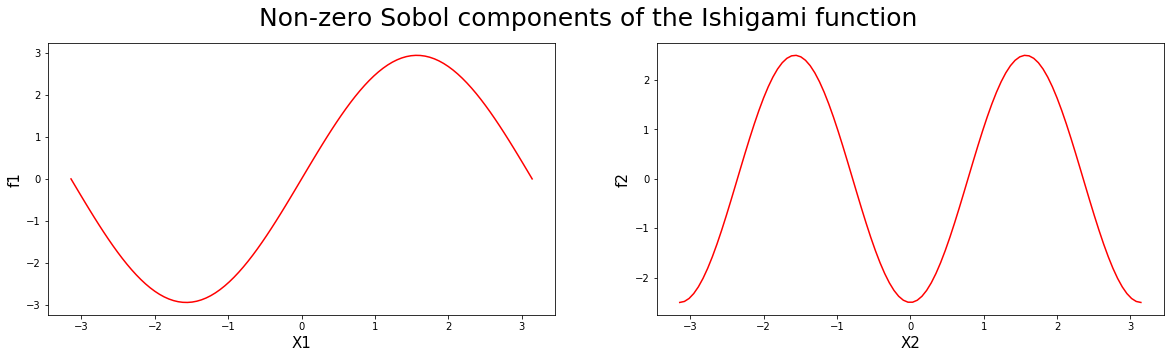

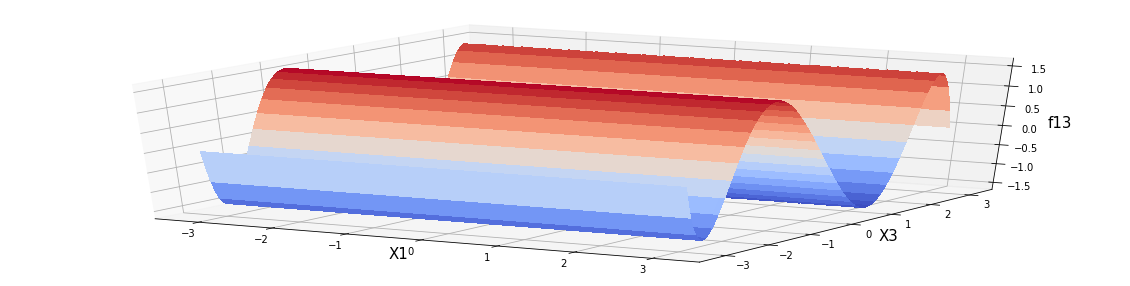

In [3]:
fig = plt.figure(figsize=(20, 5))
plt.clf()

plt.subplot(1,2,1)
plt.plot(x_grid,ishigami.f1(x_grid),'-r')
plt.xlabel('X1', fontsize=AXIS_SIZE)
plt.ylabel('f1', fontsize=AXIS_SIZE)

plt.subplot(1,2,2)
plt.plot(x_grid,ishigami.f2(x_grid),'-r')
plt.xlabel('X2', fontsize=AXIS_SIZE)
plt.ylabel('f2', fontsize=AXIS_SIZE)

plt.suptitle('Non-zero Sobol components of the Ishigami function', fontsize=TITLE_SIZE)

X, Y = np.meshgrid(x_grid, x_grid)
Z = ishigami.f13(np.array([x_grid,x_grid]).T)[:,None]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('X1', fontsize=AXIS_SIZE)
ax.set_ylabel('X3', fontsize=AXIS_SIZE)
ax.set_zlabel('f13', fontsize=AXIS_SIZE);

The total variance $Var(Y)$ in this example is

In [4]:
ishigami.variance_total

10.844587940719254

which is the sum of the variance of $V_1$, $V_2$ and $V_{13}$

In [5]:
ishigami.variance_x1, ishigami.variance_x2, ishigami.variance_x13

(4.345888023894163, 3.125, 3.373699916825092)

as we can easily show:

In [6]:
ishigami.variance_x1 + ishigami.variance_x2 + ishigami.variance_x13

10.844587940719254

## 2. First order Sobol indices using Monte Carlo

The first order Sobol indexes are a measure of "first order sensitivity" of each input variable. They account for the proportion of variance of $Y$ explained by changing each variable alone while marginalizing over the rest. The Sobol index of the $ith$ variable is simply computed as 

$$S_i = \frac{V_i}{\operatorname{Var}(Y)}.$$

This value is standardized using the total variance so it is possible to account for a fractional contribution of each variable to the total variance of the output.

The Sobol indexes for higher order interactions $S_{ij}$ are computed similarly. Note that the sum of all Solbol indexes equals to one.

In most cases we are interested in the first order indexes. In the Ishigami function their values are:|

In [7]:
ishigami.main_effects

{'x1': 0.4007425683345906, 'x2': 0.28816217057600235, 'x3': 0.0}

The most standard way of computing the Sobol indexes is using Monte Carlo. For the interested reader, the paper [Sobol, 2001](https://www.sciencedirect.com/science/article/abs/pii/S0378475400002706) contains the detail of how they can be computed. 

With Emukit, the first-order Sobol indexes can be easily computed. We first need to define the space where of target simulator is analyzed.

In [8]:
from emukit.core import ContinuousParameter, ParameterSpace

target_simulator = ishigami.fidelity1
variable_domain = (-np.pi,np.pi)

space = ParameterSpace([ContinuousParameter('x1', variable_domain[0], variable_domain[1]), 
                        ContinuousParameter('x2', variable_domain[0], variable_domain[1]),
                        ContinuousParameter('x3', variable_domain[0], variable_domain[1])])

Compute the indexes is as easy as doing

In [9]:
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
np.random.seed(10)  # for reproducibility

num_mc = 10000  # Number of MC samples
senstivity_ishigami = ModelFreeMonteCarloSensitivity(target_simulator, space)
main_effects, total_effects, _ = senstivity_ishigami.compute_effects(num_monte_carlo_points = num_mc)
main_effects

{'x1': 0.4046972807643724,
 'x2': 0.3009852695451654,
 'x3': -0.0023884465643921227}

We compare the true effects with the Monte Carlo effects in a bar-plot. The total effects are discussed later.

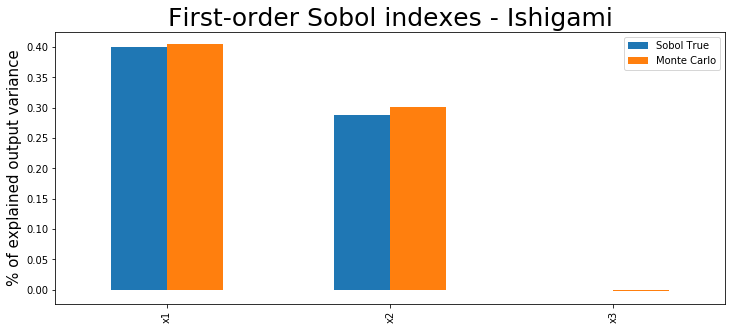

In [10]:
import pandas as pd

d = {'Sobol True': ishigami.main_effects,
     'Monte Carlo': main_effects}

pd.DataFrame(d).plot(kind='bar',figsize=(12, 5))
plt.title('First-order Sobol indexes - Ishigami', fontsize=TITLE_SIZE)
plt.ylabel('% of explained output variance',fontsize=AXIS_SIZE);

## 3. Total Effects using Monte Carlo

Computing high order sensitivity indexes can be computationally very demanding in high dimensional scenarios and measuring the total influence of each variable on the variance of the output is infeasible. To solve this issue the *total* indexes are used which account for the contribution to the output variance of $X_i$ including all variance caused by the variable alone and all its interactions of any order. The total effect for $X_i$ is given by:

$$ S_{Ti} = \frac{E_{\textbf{X}_{- i}} \left(\operatorname{Var}_{X_i} (Y \mid \mathbf{X}_{- i}) \right)}{\operatorname{Var}(Y)} = 1 - \frac{\operatorname{Var}_{\textbf{X}_{-i}} \left(E_{X_i} (Y \mid \mathbf{X}_{- i}) \right)}{\operatorname{Var}(Y)}$$

Note that the sum of $S_{Ti}$ is not necessarily one in this case unless the model is additive. In the Ishigami example the value of the total effects is

In [11]:
ishigami.total_effects

{'x1': 0.7118378294239976, 'x2': 0.28816217057600235, 'x3': 0.3110952610894071}

As in the previous example, the total effects can be computed with Monte Carlo. In the next plot we show the comparison with the true total effects.

Text(0, 0.5, 'Effects value')

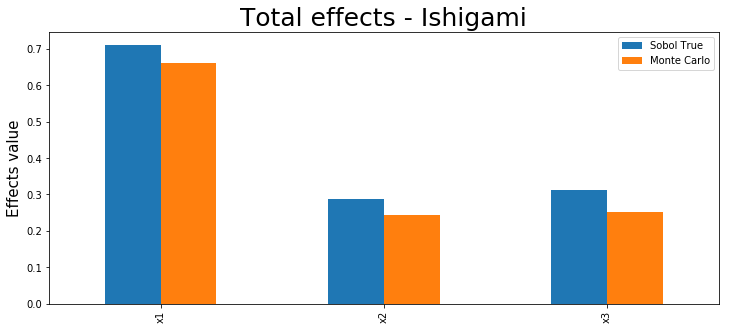

In [12]:
d = {'Sobol True': ishigami.total_effects,
     'Monte Carlo': total_effects}

pd.DataFrame(d).plot(kind='bar',figsize=(12, 5))
plt.title('Total effects - Ishigami', fontsize=TITLE_SIZE)
plt.ylabel('Effects value',fontsize=AXIS_SIZE)

## 4. Computing the sensitivity coefficients using the output of a model

In the example used above the Ishigami function is very cheap to evaluate. However, in most real scenarios the functions of interest are expensive and we need to limit ourselves to a few number of evaluations. Using Monte Carlo methods is infeasible in these scenarios as a large number of samples are typically required to provide good estimates of the Sobol coefficients.

An alternative in these cases is to use Gaussaian process emulator of the function of interest trained on a few inputs and outputs. If the model is properly trained, its mean prediction which is cheap to evaluate, can be used to compute the Monte Carlo estimates of the Sobol coefficients. Let's see how we can do this in Emukit.


We start by generating 100 samples in the input domain. Note that this a just 1% of the number of samples that we used to compute the Sobol coefficients using Monte Carlo.

In [13]:
from emukit.experimental_design.model_free.random_design import RandomDesign
desing = RandomDesign(space)
X = desing.get_samples(500)
Y  = ishigami.fidelity1(X)[:,None]

Now, we fit a standard Gaussian process to the samples and we wrap it as an Emukit model.

In [14]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

model_gpy = GPRegression(X,Y)
model_emukit = GPyModelWrapper(model_gpy)

The final step is to compute the coefficients using the class `ModelBasedMonteCarloSensitivity` which directly calls the model and uses its predictive mean to compute the Monte Carlo estimates of the Sobol indices. We plot the true estimates, those computed using 10000 direct evaluations of the objecte using Monte Carlo and those computed using a Gaussian process model trained on 100 evaluations.

In [15]:
senstivity_ishigami_gpbased = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity_ishigami_gpbased.compute_effects(num_monte_carlo_points = num_mc)

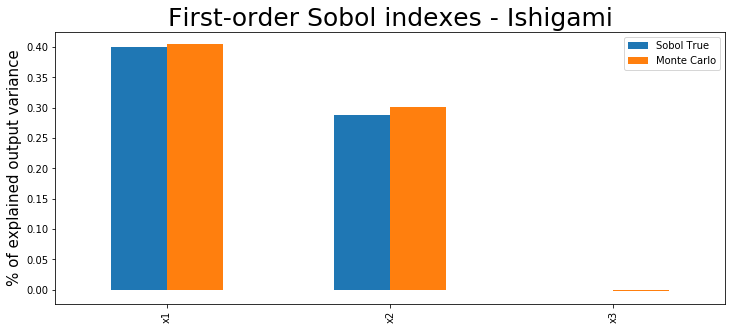

In [16]:
d = {'Sobol True': ishigami.main_effects,
     'Monte Carlo': main_effects,
     'GP Monte Carlo':main_effects_gp}

pd.DataFrame(d).plot(kind='bar',figsize=(12, 5))
plt.title('First-order Sobol indexes - Ishigami', fontsize=TITLE_SIZE)
plt.ylabel('% of explained output variance',fontsize=AXIS_SIZE);

We observe some discrepacies with respect to the real value of the coefficient when using the Gaussian process but we get a fairly good a approximation a very reduced number of evaluations of the original target function.

## 5. Conclusions

The Sobol indexes are an interesting tool to explain the variance of the output of a function as components of the input variables. Monte Carlo is an approach for computing these indexes if the function is cheap to evaluate. Other approaches will be needed if $f$ is expensive to compute.

## 6. References

- Sobol, I.M. (2001), *Global sensitivity indices for nonlinear mathematical models and their Monte Carlo estimates.* MATH COMPUT SIMULAT,55(1–3),271-280, DOI:10.1016/S0378-4754(00)00270-6
 
- Sobol’, I. (1990). *Sensitivity estimates for nonlinear mathematical models.* Matematicheskoe Modelirovanie 2, 112–118. in Russian, translated in English in Sobol’ , I. (1993).
 
- Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D. Saisana, M., and Tarantola, S., 2008, *Global Sensitivity Analysis.* The Primer, John Wiley & Sons.

- Andrea Saltelli, Paola Annoni, Ivano Azzini, Francesca Campolongo, Marco Ratto, and Stefano Tarantola. *Variance based sensitivity analysis of model output*. Design and estimator for the total sensitivity index. Computer Physics Communications, 181(2):259{270, 2010

- Kennedy, M.C. and O'Hagan, A., 2000. *Predicting the output from a complex computer code when fast approximations are available.* Biometrika, 87(1), pp.1-13.